In [17]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe
from jcopml.utils import save_model

# Import Data

In [5]:
df = pd.read_csv("data/sentiment_amazon.csv")
df.head()

,RATING,VERIFIED_PURCHASE,10,100,12,13,14,15,20,25,...,year,yellow,yes,yet,youll,young,youre,zipper,zoom,LABEL
0,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,netral
1,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,positif
2,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,positif
3,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,positif
4,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,positif


# Splitting Data

In [6]:
X = df.drop(columns="LABEL")
y = df.LABEL

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16800, 1402), (4200, 1402), (16800,), (4200,))

# Preprocessing

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from hekalml.parameter_tuning import random_search_params as rsp

In [8]:
rsp.knn_params

{'algo__n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x2bf4a33c750>,
 'algo__weights': ['uniform', 'distance'],
 'algo__p': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x2bf4a338910>}

In [9]:
X_train.columns

Index(['RATING', 'VERIFIED_PURCHASE', '10', '100', '12', '13', '14', '15',
       '20', '25',
       ...
       'yard', 'year', 'yellow', 'yes', 'yet', 'youll', 'young', 'youre',
       'zipper', 'zoom'],
      dtype='object', length=1402)

In [14]:
df.LABEL.value_counts()

LABEL
positif    18648
negatif     2055
netral       297
Name: count, dtype: int64

In [15]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), X_train.columns),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsClassifier())
])

model = RandomizedSearchCV(pipeline, rsp.knn_params, cv=5, scoring='f1_weighted', n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'algo__n_neighbors': 35, 'algo__p': 1.591297787707727, 'algo__weights': 'distance'}
1.0 0.8907207463451027 0.8911295398116971


# Accuracy Test

In [18]:
y_pred = model.predict(X_test)

In [19]:
from sklearn.metrics import classification_report


print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=df.LABEL.unique(), zero_division=0))


Classification Report:
               precision    recall  f1-score   support

      netral       0.59      0.40      0.48       411
     positif       0.83      0.08      0.15        59
     negatif       0.93      0.97      0.95      3730

    accuracy                           0.90      4200
   macro avg       0.78      0.49      0.53      4200
weighted avg       0.89      0.90      0.89      4200



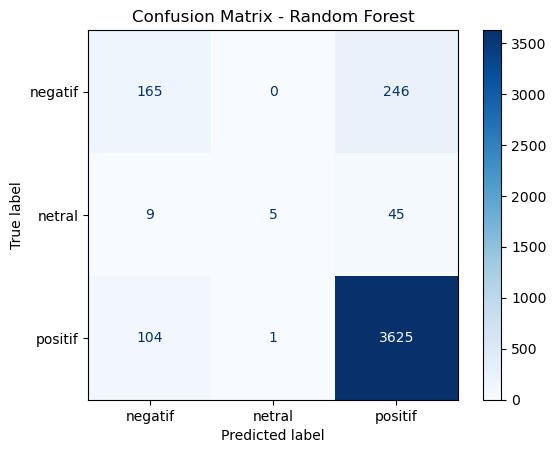

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Save Model

In [16]:
save_model(model.best_estimator_, "sentiment_knn.pkl")

Model is pickled as model/sentiment_knn.pkl
